<img src='images/TransmissionData.png' width='280px' style="float:left;margin-right:10pt;margin-top:20pt"></img>
# The NWHypergraph library for optimizing Static Hypergraph methods

The Transmission Problem: In this tutorial we highlight the use of the NWHy library with HNX. We use a synthetically generated dataset to simulate the many to many relationship between a small group of **senders** of magazine or social media subscriptions and a large group of **receivers**. 


**This tutorial requires NWHy to be installed in your environment. Please see the documentation for installation instructions.**

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import cm
from collections import OrderedDict, defaultdict
import pandas as pd
import numpy as np

import hypernetx as hnx
from hypernetx.utils.toys import TransmissionProblem

In [2]:
df = TransmissionProblem().df
print(df.shape)
df.head()

(34204, 2)


,receivers,senders
0,r0,s27
1,r1,s3
2,r2,s40
3,r3,s2
4,r4,s4


# NWHypergraph

A `pandas.Dataframe`, `df`, may be passed to the hypergraph constructor if no cell contains a nan.  
By default the first column will correspond to edges and the second column to nodes. 
You may specify which columns to use by passing in `df[[edge_column_name,node_column_name]]` to the constructor.

Because our example is large (34204 rows) we will use the NWHy api.

In [3]:
%%time
H = hnx.Hypergraph(df, use_nwhy=True)

# CPU times: user 4.83 s, sys: 1.4 ms, total: 4.83 s
# Wall time: 4.82 s

CPU times: user 4.87 s, sys: 14.2 ms, total: 4.88 s
Wall time: 4.84 s


In [4]:
H.shape ## (senders,receivers)

(45, 16866)

In [5]:
### NWHy generates a NWHy hypergraph object
H.g

### Compute the edge size and node degree distributions

In [8]:
%%time
ed = H.g.edge_size_dist()
nd = H.g.node_size_dist()

CPU times: user 1.29 ms, sys: 0 ns, total: 1.29 ms
Wall time: 452 µs


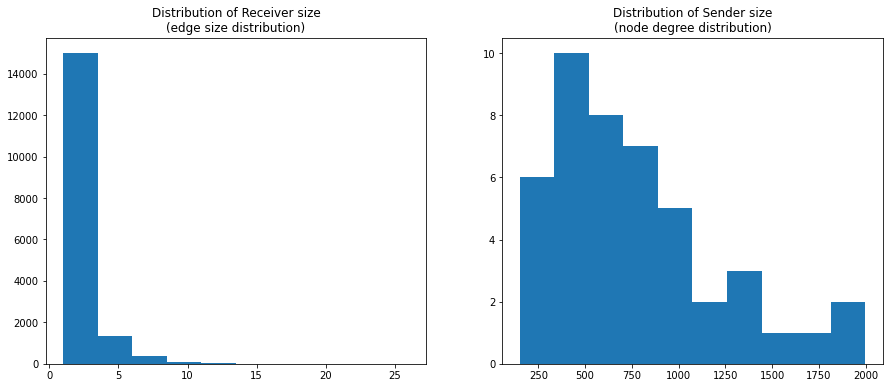

In [9]:
fig,ax = plt.subplots(1,2,figsize=(15,6))
ax[0].hist(ed)
ax[0].set_title('Distribution of Receiver size\n(edge size distribution)')
ax[1].hist(nd)
ax[1].set_title('Distribution of Sender size\n(node degree distribution)');

### Collapse the edges which contain the same nodes.

In [10]:
%%time
Hc,equiv_classes = H.collapse_edges(return_equivalence_classes=True)

# CPU times: user 16.1 s, sys: 72.8 ms, total: 16.1 s
# Wall time: 16.1 s

CPU times: user 16.1 s, sys: 38.9 ms, total: 16.1 s
Wall time: 16.1 s


In [11]:
## This reduced the number of edges by about 75%
H.shape,Hc.shape

((45, 16866), (45, 4619))

### Identify The Largest Edges in the Collapsed Hypergraph

In [12]:
%%time
ed = Hc.g.edge_size_dist()
nd = Hc.g.node_size_dist()

CPU times: user 229 µs, sys: 17 µs, total: 246 µs
Wall time: 187 µs


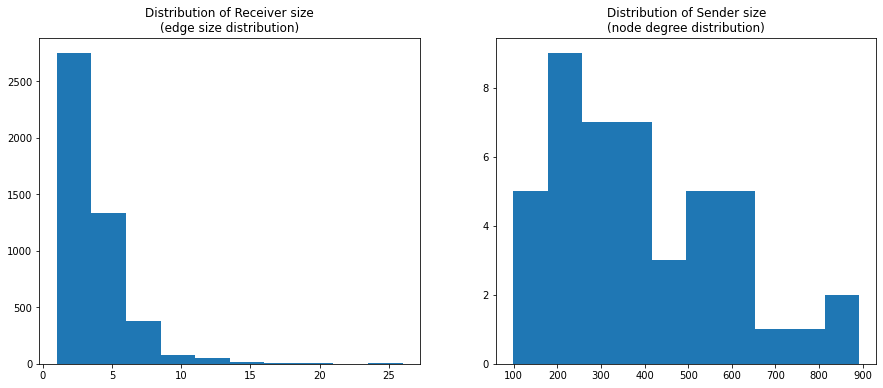

In [13]:
fig,ax = plt.subplots(1,2,figsize=(15,6))
ax[0].hist(ed)
ax[0].set_title('Distribution of Receiver size\n(edge size distribution)')
ax[1].hist(nd)
ax[1].set_title('Distribution of Sender size\n(node degree distribution)');

### Good Receivers: Restrict to Receivers connected to more than a fixed number of senders and compute their metrics

In [14]:
## restrict to receivers who are connected to more than K senders: |r|>K
K=10
good_receivers = [r for r in Hc.edges if Hc.size(r)>K]
len(good_receivers)

84

In [15]:
Hgr = Hc.restrict_to_edges(good_receivers)

In [16]:
Hgr.shape

(45, 84)

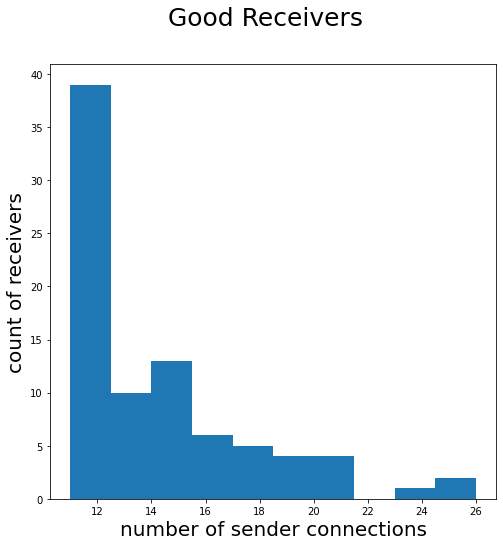

In [17]:
## Size Distribution
fig,ax = plt.subplots()
fig.suptitle('Good Receivers',fontsize=25)
ax.hist(hnx.dist_stats(Hgr)['edge size list'])
ax.set_xlabel('number of sender connections',fontsize=20)
ax.set_ylabel('count of receivers',fontsize=20);

# S-Metrics

## Line Graphs 
HNX uses s-linegraphs to compute graph-like statistics on hypergraphs. We use NetworkX (Python) and NWHypergraph (C++) to compute the statistics. The library chosen depends on the size of the hypergraph and whether or not NWHy is available.

**Node Line Graphs** -> H-nodes become Nodes in the Graph 
- s-connected if they commonly belong to s H-edges

**Edge Line Graphs** -> H-edges become Nodes in the Graph 
- s-connected if they intersect in s H-nodes 

<img src='images/s-width.png' width='500px' style="float:left;margin-right:30pt"></img>


## S-Linegraph

By default the `s_component_subgraphs` method defines s-connectivity using the edge s-linegraph. To define connectivity in terms of the node linegraph set edges=False in the signature. Here we will compute the s-connected component subgraphs and the centrality of the edges in the non-trivial components. 

Singleton components are only returned if return_singletons=True.


In [18]:
%%time

comps = {s: list(Hgr.s_component_subgraphs(s=s, edges=True, return_singletons=False)) for s in range(1,25)}

# CPU times: user 7.37 s, sys: 83.2 ms, total: 7.45 s
# Wall time: 7.3 s

CPU times: user 7.34 s, sys: 32.2 ms, total: 7.37 s
Wall time: 7.25 s


### Note there is only one non-trivial s_connected_component for each value of s

In [19]:
compdf = pd.DataFrame(columns=['s','#-non-trivial','shape'])
for s,v in comps.items():
    if len(v) !=0:
        compdf = compdf.append([dict(zip(['s','#-non-trivial','shape'],
                                [s,len(comps[s]),comps[s][0].shape]))],ignore_index=True)
    else:
        compdf = compdf.append([dict(zip(['s','#-non-trivial','shape'],
                                [s,0,(0,0)]))],ignore_index=True)
compdf

,s,#-non-trivial,shape
0,1,1,"(45, 84)"
1,2,1,"(45, 84)"
2,3,1,"(45, 84)"
3,4,1,"(45, 84)"
4,5,1,"(45, 84)"
5,6,1,"(45, 84)"
6,7,1,"(45, 84)"
7,8,1,"(45, 83)"
8,9,1,"(45, 75)"
9,10,1,"(45, 56)"


## Centrality Statistics:

We compute the s-centrality edge statistics for $1 \leq s < 20$. We then examine plots to compare the values across the edges.

### s-closeness centrality
If $u$ is a vertex in one of the s-line graphs above, the s-closeness centrality is computed on each of the connected components

$V$ = the set of vertices in the linegraph.  
$n = |V|$
$$C(u) = \frac{n - 1}{\sum_{v \neq u \in V} d(v, u)}$$

In [20]:
If $u$ is a vertex in one of the s-line graphs above, the s-closeness centrality is computed on each of the connected components

$V$ = the set of vertices in the linegraph.  
$n = |V|$
$$C(u) = \frac{n - 1}{\sum_{v \neq u \in V} d(v, u)}$$%%time
scc = dict()
for s in range(1,20):
    scc[s] = hnx.s_closeness_centrality(comps[s][0],s=s,edges=True,use_nwhy=True)
    
# CPU times: user 7.41 s, sys: 122 ms, total: 7.53 s
# Wall time: 7.18 s

CPU times: user 7.47 s, sys: 68.9 ms, total: 7.54 s
Wall time: 7.26 s


### s-betweenness centrality
The centrality of edge to all shortest s-edge paths
$V$ = the set of vertices in the linegraph.  
$\sigma(s,t)$ = the number of shortest paths between vertices $s$ and $t$.  
$\sigma(s, t|v)$ = the number of those paths that pass through vertex $u$
$$c_B(u) =\sum_{s \neq t \in V} \frac{\sigma(s, t|u)}{\sigma(s, t)}$$

In [21]:
%%time
sbc = dict()
for s in range(1,20):
    sbc[s] = hnx.s_betweenness_centrality(comps[s][0],s=s,edges=True,use_nwhy=True)
    
# CPU times: user 7.43 s, sys: 48.1 ms, total: 7.48 s
# Wall time: 7.37 s

CPU times: user 7.26 s, sys: 54 ms, total: 7.32 s
Wall time: 7.19 s


### s-harmonic centrality - 

The denormalized reciprocal of the harmonic mean of all distances from $u$ to all other vertices.  
$V$ = the set of vertices in the linegraph.
$$C(u) = \sum_{v \neq u \in V} \frac{1}{d(v, u)}$$

Normalized this becomes:
$$C(u) = \sum_{v \neq u \in V} \frac{1}{d(v, u)}\cdot\frac{2}{(n-1)(n-2)}$$
where $n$ is the number vertices.

In [22]:
%%time
shc = dict()
for s in range(1,20):
    shc[s] = hnx.s_harmonic_centrality(comps[s][0],s=s,edges=True,use_nwhy=True)
    
# CPU times: user 7.53 s, sys: 98.5 ms, total: 7.63 s
# Wall time: 7.35 s

CPU times: user 7.38 s, sys: 65.7 ms, total: 7.45 s
Wall time: 7.17 s


In [23]:
%%time
shcn = dict()
for s in range(1,20):
    shcn[s] = hnx.s_harmonic_centrality(comps[s][0],s=s,edges=True,use_nwhy=True,normalized=True)
    
# CPU times: user 7.68 s, sys: 50.1 ms, total: 7.73 s
# Wall time: 7.53 s

CPU times: user 7.33 s, sys: 60.7 ms, total: 7.39 s
Wall time: 7.16 s


### s-eccentricity -
The length of the longest shortest path from a vertex $u$ to every other vertex in the linegraph.  
$V$ = set of vertices in the linegraph
$$ \text{s-ecc}(u) = \text{max}\{d(u,v): v \in V\} $$

In [24]:
%%time
sec = dict()
for s in range(1,20):
    sec[s] = hnx.s_eccentricity(comps[s][0],s=s,edges=True,use_nwhy=True)
    
# CPU times: user 7.66 s, sys: 50.7 ms, total: 7.71 s
# Wall time: 7.49 s

CPU times: user 7.39 s, sys: 43.1 ms, total: 7.44 s
Wall time: 7.26 s


## Plot the centrality metrics

In [25]:
scex = [scc,sbc,shc,shcn,sec]
scnames = ['s-Closeness Centrality','s-Betweenness Centrality',
           's-Harmonic Centrality','s-Harmonic Centrality normalized','s-Eccentricity']

In [26]:
## specify which centrality to view from scnames by index
i = 0 ## index of centrality score type
ex = scex[i]  ## dictionary of centrality scores keyed by s

In [27]:
## Collect points to plot
S = sorted(ex.keys()) ## all s values we are evaluating
indexdict = defaultdict(list) ## nd position in each s by centrality score
valdict = dict() ## s:{score:[nds]} groups nodes by their scores
vals = dict()
for s in S:
    d = defaultdict(list) ## temporary score:[nds] dictionary
    for nd,val in ex[s].items():
        d[val].append(nd)
    vals[s] = sorted(list(d.keys()),reverse=True) ## sort keys of scores large to small
    for vdx,val in enumerate(vals[s]):
        for nd in d[val]:
                indexdict[nd].append(vdx)  ## nd: position indexed by s
    valdict[s] = OrderedDict([(vdx,d[val]) for vdx,val in enumerate(vals[s])]) ## organize scores by value

yindex = defaultdict(list)
for sdx,s in enumerate(S):    
    for k,nds in valdict[s].items():
        ## sorts elements with the same score by successive scores - lexi-like
        yindex[s] += sorted(list(nds),key = lambda nd : sum(indexdict[nd][sdx:])) 
        
specpos = defaultdict(list) ## plots by relative position in ordering
specvals = defaultdict(list) ## plots by value

## generate points
for s in S:
    topval = Hgr.shape[1]
    for ndx,nd in enumerate(yindex[s]):
        specpos[nd].append(topval-ndx)
        specvals[nd].append([s,vals[s][indexdict[nd][s-1]]])
        
## set up for plotting
for nd in specpos:
    specpos[nd] = np.array(specpos[nd]) ## an array for plotting sequential positions
    specvals[nd] = np.array(specvals[nd]).T  ## x,y arrays
    


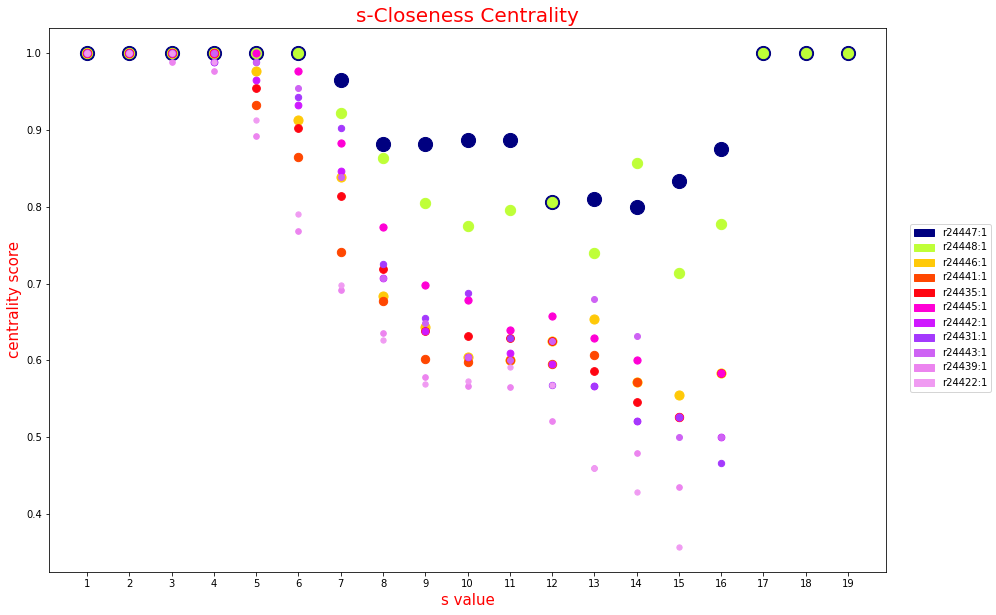

In [28]:
## Plot by value

s = 15  ## limit to nodes in s-linegraph
N = len(yindex[s])
_cmap = cm.gist_ncar

K1 = 20  ## constant spreads out colors so that they don't bunch up at the beginning
colors = [idx/100 for idx in K1*np.log(np.linspace(1,100,N))]  
cmap = lambda idx : _cmap(colors[idx])

K2 = 35  ## constant reduces size tapering off at the end
stops = K2*np.log(np.linspace(1,150,N+1)) ## reduce size to prevent occlusion

nodes = list(yindex[s]) ## plot values only for nodes still around for this value of s

fig,ax = plt.subplots(figsize=(15,10))

patch = dict()
for idx,nd in enumerate(nodes):
    ax.scatter(specvals[nd][0], specvals[nd][1], s=200-stops[idx], color=cmap(idx))
    patch[nd] = mpatches.Patch(color=cmap(idx), label=nd)
#     ax.scatter(specvals[nd][0],specvals[nd][1], s=200-15*idx, color=cmap(colors[idx]))

ax.set_title(scnames[i],fontsize=20,color='r')
ax.set_xticks(range(1,20))
# ax.set_yticks(np.linspace(0,1,11))
ax.set_xlabel('s value',fontsize=15,color='r')
ax.set_ylabel('centrality score',fontsize=15,color='r')


fig.legend(handles=[patch[nd] for nd in nodes],loc="right");

### Positional Plot - receivers ordered by centrality value

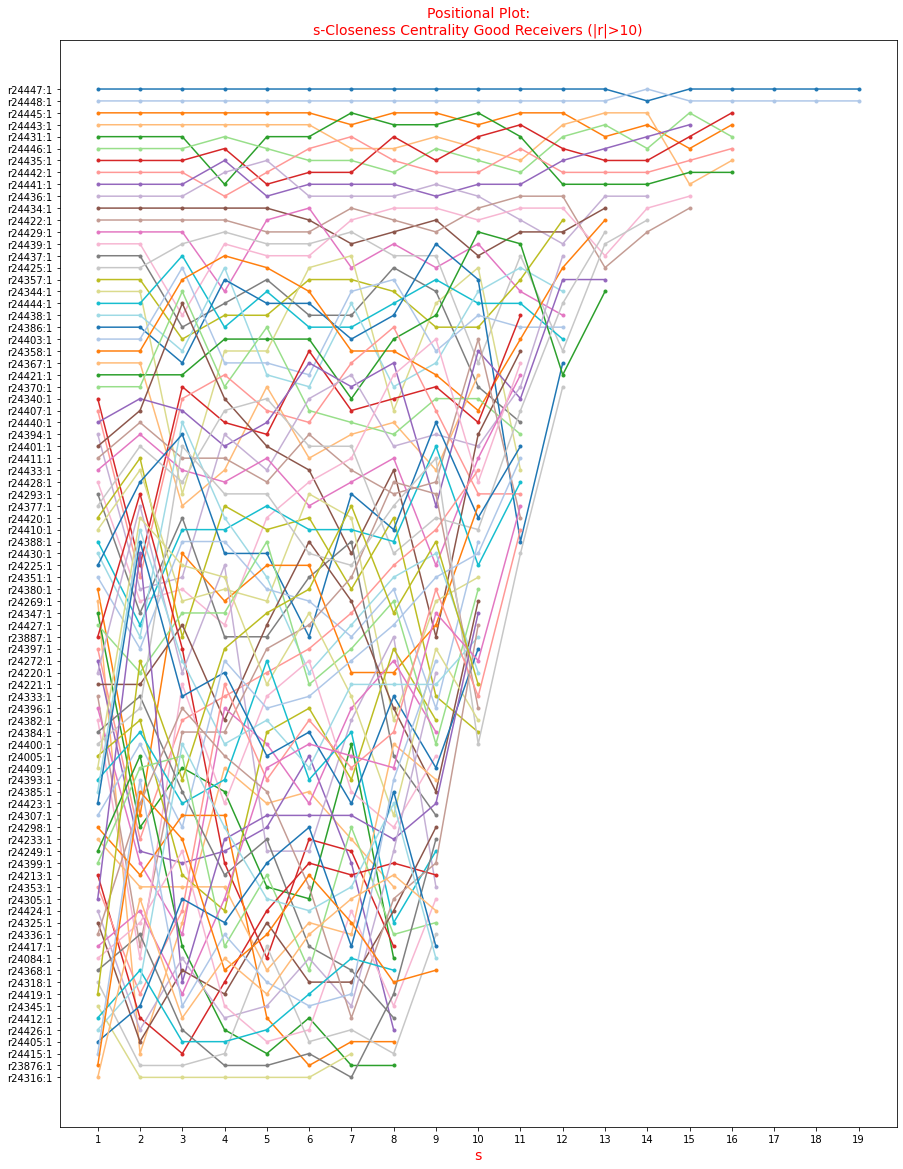

In [29]:
## Positional plot starting at specified s value
_cmap = cm.tab20
cmap = lambda idx : _cmap(idx%20)

starts = 1  ## Limits first xtick to show in plot
starts -=1
fig,ax = plt.subplots(1,1,figsize=(15,20))
ax.set_yticks([v[0] for v in specpos.values()])
ax.set_yticklabels([k for k in specpos])
ax.set_xticks(range(20-starts))
ax.set_xticklabels([str(x+1) for x in range(starts,20)])

ax.set_xlabel('s',fontsize=14,color='r')

for idx,nd in enumerate(specpos):
    if len(specpos[nd]) == 0:
        continue
    ax.plot(specpos[nd][starts:],marker='.', color = cmap(idx))

plt.title(f'Positional Plot:\n{scnames[i]} Good Receivers (|r|>{K})',fontsize=14,color='r');

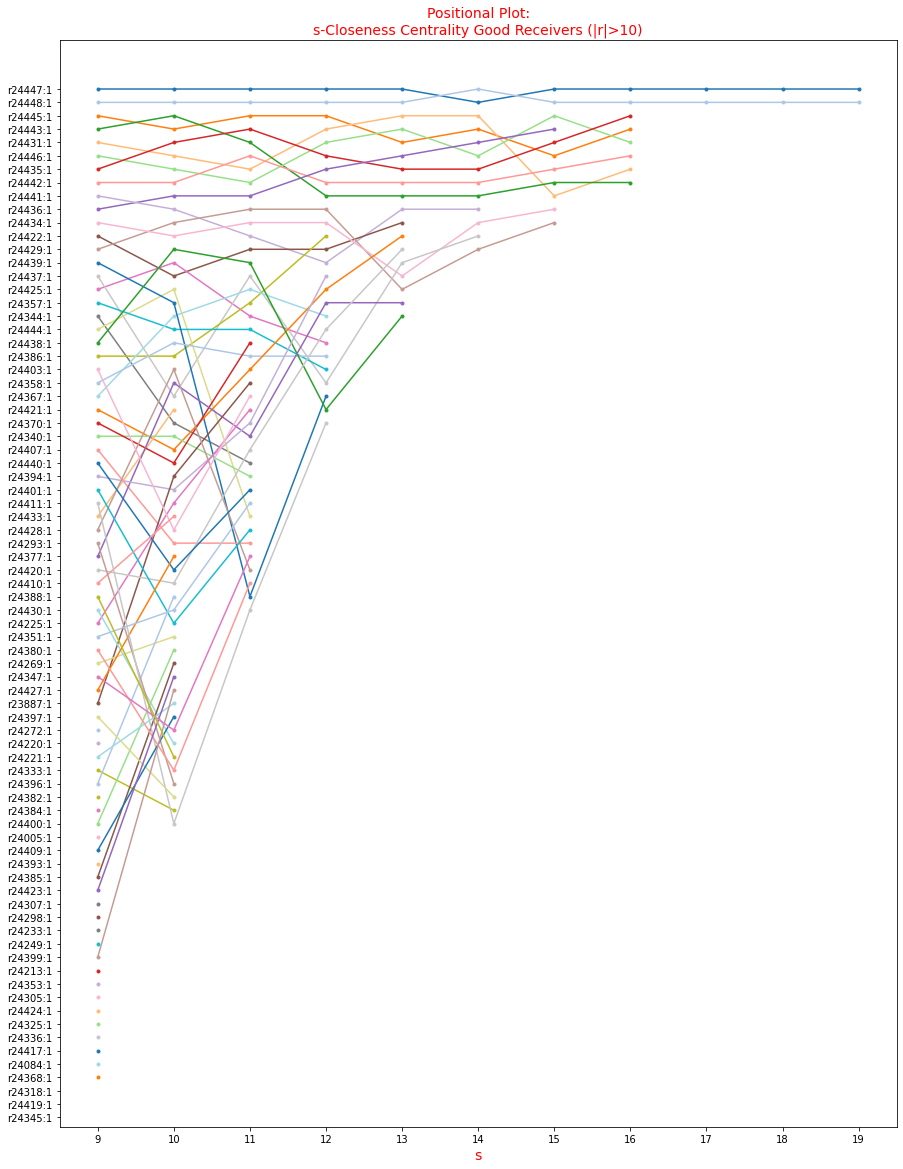

In [30]:
## Positional plot starting at specified s value
_cmap = cm.tab20
cmap = lambda idx : _cmap(idx%20)

starts = 9  ## Limits first xtick to show in plot
starts -=1
fig,ax = plt.subplots(1,1,figsize=(15,20))
ax.set_yticks([v[0] for v in specpos.values()])
ax.set_yticklabels([k for k in specpos])
ax.set_xticks(range(20-starts))
ax.set_xticklabels([str(x+1) for x in range(starts,20)])

ax.set_xlabel('s',fontsize=14,color='r')

for idx,nd in enumerate(specpos):
    if len(specpos[nd]) == 0:
        continue
    ax.plot(specpos[nd][starts:],marker='.', color = cmap(idx))

plt.title(f'Positional Plot:\n{scnames[i]} Good Receivers (|r|>{K})',fontsize=14,color='r');